System information (for reproducibility):

In [6]:
versioninfo()

Julia Version 1.10.2
Commit bd47eca2c8a (2024-03-01 10:14 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: macOS (x86_64-apple-darwin22.4.0)
  CPU: 12 × Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, skylake)
Threads: 1 default, 0 interactive, 1 GC (on 12 virtual cores)


Load packages:

In [7]:
using Pkg
#Pkg.resolve()
#Pkg.update()
Pkg.activate(pwd())
Pkg.instantiate()
Pkg.status()


  Activating project at `~/Documents/GitHub/biostat-m257-2024-spring/hw2`


Status `~/Documents/GitHub/biostat-m257-2024-spring/hw2/Project.toml`
  [6e4b80f9] BenchmarkTools v1.5.0
  [8bb1440f] DelimitedFiles v1.9.1
  [7073ff75] IJulia v1.24.2
  [916415d5] Images v0.26.1
  [bdcacae8] LoopVectorization v0.12.169
  [08abe8d2] PrettyTables v2.3.1
  [37e2e46d] LinearAlgebra
  [9abbd945] Profile


In [8]:
# load libraries
using BenchmarkTools, DelimitedFiles, Images, LinearAlgebra, LoopVectorization
using Profile, Random

## Q1. Nonnegative Matrix Factorization

Nonnegative matrix factorization (NNMF) was introduced by [Lee and Seung (1999)](https://www.nature.com/articles/44565) as an alternative to principal components and vector quantization with applications in data compression, clustering, and deconvolution. In this homework we consider algorithms for fitting NNMF and (optionally) high performance computing using graphical processing units (GPUs).

<img src="./nnmf.png" width="500" align="center"/>

In mathematical terms, one approximates a data matrix $\mathbf{X} \in \mathbb{R}^{m \times n}$ with nonnegative entries $x_{ij}$ by a product of two low-rank matrices $\mathbf{V} \in \mathbb{R}^{m \times r}$ and $\mathbf{W} \in \mathbb{R}^{r \times n}$ with nonnegative entries $v_{ik}$ and $w_{kj}$. Consider minimization of the squared Frobenius norm
$$
L(\mathbf{V}, \mathbf{W}) = \|\mathbf{X} - \mathbf{V} \mathbf{W}\|_{\text{F}}^2 = \sum_i \sum_j \left(x_{ij} - \sum_k v_{ik} w_{kj} \right)^2, \quad v_{ik} \ge 0, w_{kj} \ge 0,
$$
which should lead to a good factorization. Lee and Seung suggest an iterative algorithm with multiplicative updates
$$
v_{ik}^{(t+1)} = v_{ik}^{(t)} \frac{\sum_j x_{ij} w_{kj}^{(t)}}{\sum_j b_{ij}^{(t)} w_{kj}^{(t)}}, \quad \text{where } b_{ij}^{(t)} = \sum_k v_{ik}^{(t)} w_{kj}^{(t)},
$$
$$
w_{kj}^{(t+1)} = w_{kj}^{(t)} \frac{\sum_i x_{ij} v_{ik}^{(t+1)}}{\sum_i b_{ij}^{(t+1/2)} v_{ik}^{(t+1)}}, \quad \text{where } b_{ij}^{(t+1/2)} = \sum_k v_{ik}^{(t+1)} w_{kj}^{(t)}
$$
that will drive the objective $L^{(t)} = L(\mathbf{V}^{(t)}, \mathbf{W}^{(t)})$ downhill. Superscript $t$ indicates the iteration number. In following questions, efficiency (both speed and memory) will be the most important criterion when grading this problem.

### Q1.1 Develop code

Implement the algorithm with arguments: $\mathbf{X}$ (data, each row is a vectorized image), rank $r$, convergence tolerance, and optional starting point.

### Solution

In [9]:
function nnmf(
    # positional arguments
    X       :: AbstractMatrix{T}, 
    r       :: Integer;
    # kw arguments
    XtX     :: Number = dot(X, X),
    maxiter :: Integer = 1000, 
    tolfun  :: Number = 1e-4,
    V       :: AbstractMatrix{T} = Random.rand!(similar(X, size(X, 1), r)),
    W       :: AbstractMatrix{T} = Random.rand!(similar(X, r, size(X, 2))),
    XWt     :: AbstractMatrix{T} = zeros(size(X, 1), r),
    BWt     :: AbstractMatrix{T} = zeros(size(X, 1), r),
    VtX     :: AbstractMatrix{T} = zeros(r, size(X, 2)),
    VtB     :: AbstractMatrix{T} = zeros(r, size(X, 2)),
    VtV     :: AbstractMatrix{T} = zeros(r, r),
    WWt     :: AbstractMatrix{T} = zeros(r, r),    
    obj     :: Number = 0,
    obj_old :: Number = 0
    ) where T <: AbstractFloat
    # TODO: implementation
    # TODO: obj at start point 
    #input the start value of obj manully or just use 0.
    
    # TODO: Loop
    niter = 0
    for iter in 1:maxiter
        # update V
        mul!(XWt, X, transpose(W))
        
        mul!(BWt, V, mul!(WWt, W, transpose(W)))
        
        V .= V .* ((XWt) ./ (BWt))
        
        # update W
        mul!(VtX, transpose(V), X)
        mul!(VtB, mul!(VtV, transpose(V), V), W)
        W .= W .* ((VtX) ./ (VtB))
        
        #make a copy of old obj
        obj_old = copy(obj)
        
        # update obj
        #Note that W is updated, so we need to update VtB as well.
        mul!(VtB, VtV, W)
        #obj = XtX + tr(transpose(W) * VtB) - 2 * tr(transpose(W) * VtX)
        obj = XtX + dot(W, VtB) - 2 * dot(W, VtX)
        
        # convergence check
        if abs(obj - obj_old) < tolfun * (abs(obj_old) + 1)
            niter = iter
            break
        end
    end
    # Output
    V, W, obj, niter
end

nnmf (generic function with 1 method)

### Q1.2 Data

Database 1 from the [MIT Center for Biological and Computational Learning (CBCL)](http://cbcl.mit.edu/software-datasets/FaceData2.html) reduces to a matrix $\mathbf{X}$ containing $m = 2,429$ gray-scale face images with $n = 19 \times 19 = 361$ pixels per face. Each image (row) is scaled to have mean and standard deviation 0.25.  

Read in the [`nnmf-2429-by-361-face.txt`](https://raw.githubusercontent.com/ucla-biostat-257/2024spring/master/hw/hw2/nnmf-2429-by-361-face.txt) file, e.g., using [`readdlm`](https://docs.julialang.org/en/v1/stdlib/DelimitedFiles/#Delimited-Files) function, and display a couple of sample images, e.g., using the [Images.jl](https://juliaimages.org/stable/) package.

### Solution

(2429, 361)


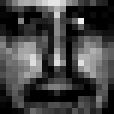

In [10]:
X = readdlm("nnmf-2429-by-361-face.txt")
println(size(X))
colorview(Gray, reshape(X[1, :], 19, 19))

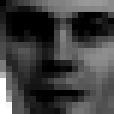

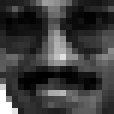

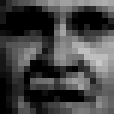

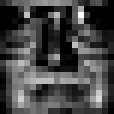

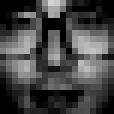

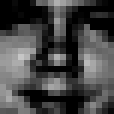

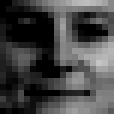

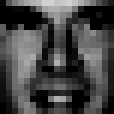

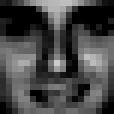

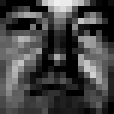

In [11]:
#Print 10 images contained in the given dataset.
for i in 1:10
    display(colorview(Gray, reshape(X[10 * i, :], 19, 19)))
end

### Q1.3 Correctness and efficiency

Report the run times, using `@btime`, of your function for fitting NNMF on the MIT CBCL face data set at ranks $r=10, 20, 30, 40, 50$. For ease of comparison (and grading), please start your algorithm with the provided $\mathbf{V}^{(0)}$ (first $r$ columns of [`V0.txt`](https://raw.githubusercontent.com/ucla-biostat-257/2024spring/master/hw/hw2/V0.txt)) and $\mathbf{W}^{(0)}$ (first $r$ rows of [`W0.txt`](https://raw.githubusercontent.com/ucla-biostat-257/2024spring/master/hw/hw2/W0.txt)) and stopping criterion
$$
\frac{|L^{(t+1)} - L^{(t)}|}{|L^{(t)}| + 1} \le 10^{-4}.
$$

**Hint**: When I run the following code using my own implementation of `nnmf`
```julia
# provided start point
V0full = readdlm("V0.txt", ' ', Float64)
W0full = readdlm("W0.txt", ' ', Float64);

# benchmarking
for r in [10, 20, 30, 40, 50]
    println("r=$r")
    V0 = V0full[:, 1:r]
    W0 = W0full[1:r, :]
    _, _, obj, niter = nnmf(X, r, V = V0, W = W0)
    @btime nnmf($X, $r, V = $V0, W = $W0) setup=(
        copyto!(V0, V0full[:, 1:r]), 
        copyto!(W0, W0full[1:r, :])
        )
    println("obj=$obj, niter=$niter")
end
```
the output is
```
r=10
  162.662 ms (9 allocations: 437.19 KiB)
obj=11730.866905748058, niter=239
r=20
  234.293 ms (9 allocations: 875.44 KiB)
obj=8497.605595863002, niter=394
r=30
  259.524 ms (9 allocations: 1.28 MiB)
obj=6621.94596847528, niter=482
r=40
  289.918 ms (9 allocations: 1.72 MiB)
obj=5256.866299829562, niter=581
r=50
  397.511 ms (10 allocations: 2.15 MiB)
obj=4430.362097310877, niter=698
```
Due to machine differences, your run times can be different from mine but certainly can not be order of magnitude longer. Your memory allocation should be less or equal to mine.

### Solution: 

In [12]:
function test_allo(X, Y)
    X - Y
end

test_allo (generic function with 1 method)

In [13]:
A = Random.rand(10, 10)
size(A)
@btime test_allo($A, $A)

  105.524 ns (1 allocation: 896 bytes)


10×10 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [14]:
B = Random.rand(1000, 1000)
size(B)
@btime test_allo($B, $B)

  753.317 μs (2 allocations: 7.63 MiB)


1000×1000 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0

Notice that the allocation number in julia is highly related to the size of allocated item, for eg, the subtraction result (X - Y) in following function. Although we are using the same function, as A and B have different size, their allocations are also different. Hence now we need to break the allocated item in our algorithm to make it as small as possible. And also if possible, preallocate items as much as we can.

In [15]:
# provided start point
V0full = readdlm("V0.txt", ' ', Float64)
W0full = readdlm("W0.txt", ' ', Float64)
println(size(V0full))
println(size(W0full))

(2429, 50)
(50, 361)


In [16]:
for r in [10, 20, 30, 40, 50]
    println("r=$r")
    m, n = size(X)
    V0 = deepcopy(V0full[:, 1 : r])
    W0 = deepcopy(W0full[1 : r, :])
    XWt0 = zeros(m, r)
    BWt0 = zeros(m, r)
    VtX0 = zeros(r, n)
    VtB0 = zeros(r, n)
    XtX0 = dot(X, X)
    VtV0  = zeros(r, r)
    WWt0  = zeros(r, r)
    _, _, obj, niter = nnmf(X, r, V = V0, W = W0, XtX = XtX0, maxiter = 1000, 
    tolfun = 1e-4, XWt = XWt0, BWt = BWt0, VtX = VtX0, VtB = VtB0, VtV = VtV0, WWt = WWt0 
    )
    println("obj=$obj, niter=$niter")
    @btime nnmf($X, $r, V = $V0, W = $W0, XtX = $XtX0, maxiter = 1000, 
    tolfun = 1e-4, XWt = $XWt0, BWt = $BWt0, VtX = $VtX0, VtB = $VtB0, VtV = $VtV0, WWt = $WWt0 
    ) setup=(
        copyto!($V0, $(V0full[:, 1 : r])), 
        copyto!($W0, $(W0full[1 : r, :]))
        )
end

r=10
obj=11730.388009854883, niter=239
  320.840 ms (2 allocations: 64 bytes)
r=20
obj=8497.222317850305, niter=394
  811.783 ms (2 allocations: 64 bytes)
r=30
obj=6621.627345486224, niter=482
  1.254 s (2 allocations: 64 bytes)
r=40
obj=5256.663870563498, niter=581
  1.733 s (3 allocations: 80 bytes)
r=50
obj=4430.201581697271, niter=698
  2.049 s (3 allocations: 80 bytes)


### Q1.4 Non-uniqueness

Choose an $r \in \{10, 20, 30, 40, 50\}$ and start your algorithm from a different $\mathbf{V}^{(0)}$ and $\mathbf{W}^{(0)}$. Do you obtain the same objective value and $(\mathbf{V}, \mathbf{W})$? Explain what you find.

### Solution

In [17]:
r = 50
m, n = size(X)
V0 = deepcopy(V0full[:, 1 : r])
W0 = deepcopy(W0full[1 : r, :])
XWt0 = zeros(m, r)
BWt0 = zeros(m, r)
VtX0 = zeros(r, n)
VtB0 = zeros(r, n)
XtX0 = dot(X, X)
VtV0  = zeros(r, r)
WWt0  = zeros(r, r)
V_pre_1, W_pre_1, obj_1, niter_1 = nnmf(X, r, V = V0, W = W0, XtX = XtX0, maxiter = 1000, 
tolfun = 1e-4, XWt = XWt0, BWt = BWt0, VtX = VtX0, VtB = VtB0, VtV = VtV0, WWt = WWt0 
)
println(V_pre_1[1 : 10, 1 : 10])
println(W_pre_1[1 : 10, 1 : 10])
println(obj_1)
println(niter_1)

[4.065152683368012e-8 0.02391830987010442 0.03684049147645144 0.0007717745770361723 0.010498902733499713 0.020377150588402212 0.007668627993523383 0.013016740803883535 1.936521277749764e-28 0.028321162266428977; 2.0669226656511503e-5 0.01676918953044334 0.026807155095314093 0.012985387192079775 0.017899852432078558 0.02021986283178161 0.00017741477404113908 0.010759472448517788 1.2574184873985358e-11 0.01995292164301744; 0.0029571103974039255 0.031056070262952068 0.0355727541138942 0.013386226372229755 0.0200795078656311 0.01362971725992806 1.0894950242341938e-8 0.011174676990424364 0.01102814220219383 0.03342977403146179; 9.571033593925102e-6 0.019988411287695445 0.03991106657965062 0.009043767590485016 0.02458793276207752 0.0074125104690388535 0.006506741395820494 0.012152887481456626 8.388164654261702e-13 0.07945643823994417; 0.011465264362575072 0.020215110818753337 0.023918001401180496 0.009158309706730783 0.022757877250916433 2.677244422335376e-12 2.1359414948267575e-10 0.0083031

In [18]:
Random.seed!(199) # seed
r = 50
m, n = size(X)
V0 = deepcopy(Random.rand(2429, 50)[:, 1 : r])
W0 = deepcopy(Random.rand(50, 361)[1 : r, :])
XWt0 = zeros(m, r)
BWt0 = zeros(m, r)
VtX0 = zeros(r, n)
VtB0 = zeros(r, n)
XtX0 = dot(X, X)
VtV0  = zeros(r, r)
WWt0  = zeros(r, r)
V_pre_2, W_pre_2, obj_2, niter_2 = nnmf(X, r, V = V0, W = W0, XtX = XtX0, maxiter = 1000, 
tolfun = 1e-4, XWt = XWt0, BWt = BWt0, VtX = VtX0, VtB = VtB0, VtV = VtV0, WWt = WWt0 
)
println(V_pre_2[1 : 10, 1 : 10])
println(W_pre_2[1 : 10, 1 : 10])
println(obj_2)
println(niter_2)

[6.538066417495421e-11 0.003978810139391513 0.019495561450665028 0.002158681139869283 1.7864770547298018e-29 2.4341409404311576e-16 0.016121279262156327 0.008862420086290311 0.026027592120295928 0.004114399007267844; 7.083104143007196e-10 5.853580321303037e-7 0.03411660339652733 0.030558290438606948 1.269264227361039e-49 5.908039359045029e-18 0.004750013993249431 9.626996884174166e-10 0.012681026440772729 0.012235194336712414; 1.5183104100508694e-25 2.6625940730407592e-8 0.01571165638909455 0.026473030611346933 1.148516874017749e-34 7.836897791334964e-15 0.008607393643580574 1.1466447070422253e-10 0.013652187940768947 0.009729968143656079; 8.76237920118752e-8 0.011246959156282056 9.411451018961091e-25 0.01647175351378067 0.0006550200763051388 1.8432202836604158e-7 0.015562411521701666 0.0031209286627609284 0.0023516375450620595 0.004463035511569012; 8.248364464248013e-15 0.001287940065847217 0.008189721124071075 0.036482511033670846 1.5758900283056743e-32 0.00295501988434169 0.01831368

In [19]:
print("Norm of the difference matrix between two estimates of V: ")
println(norm(V_pre_1 - V_pre_2))
print("Standard norm of the difference matrix between two estimates of V: ")
println(norm(V_pre_1 - V_pre_2) / length(V_pre_1))

print("Norm of the difference matrix between two estimates of W: ")
println(norm(W_pre_1 - W_pre_2))
print("Standard norm of the difference matrix between two estimates of W: ")
println(norm(W_pre_1 - W_pre_2) / length(W_pre_1))

Norm of the difference matrix between two estimates of V: 6.239258527891618
Standard norm of the difference matrix between two estimates of V: 5.1373063218539464e-5
Norm of the difference matrix between two estimates of W: 283.81941827204616
Standard norm of the difference matrix between two estimates of W: 0.015724067494296185


In [20]:
Random.seed!(399) # seed
r = 50
m, n = size(X)
V0 = deepcopy(Random.rand(2429, 50)[:, 1 : r])
W0 = deepcopy(Random.rand(50, 361)[1 : r, :])
XWt0 = zeros(m, r)
BWt0 = zeros(m, r)
VtX0 = zeros(r, n)
VtB0 = zeros(r, n)
XtX0 = dot(X, X)
VtV0  = zeros(r, r)
WWt0  = zeros(r, r)
V_pre_3, W_pre_3, obj_3, niter_3 = nnmf(X, r, V = V0, W = W0, XtX = XtX0, maxiter = 1000, 
tolfun = 1e-4, XWt = XWt0, BWt = BWt0, VtX = VtX0, VtB = VtB0, VtV = VtV0, WWt = WWt0 
)
println(V_pre_3[1 : 10, 1 : 10])
println(W_pre_3[1 : 10, 1 : 10])
println(obj_3)
println(niter_3)

[9.023785035804864e-32 1.2954238504603117e-14 0.0007945583192761185 0.00972177730882708 0.00851671944079548 2.311864623161503e-14 0.005532180967341811 0.02392368714121078 2.5273921432812877e-13 0.017883755886111026; 6.610160154794565e-17 1.1532532740082585e-11 0.011260559227936612 0.029969067704498937 0.00015640532367997904 7.165986653410197e-5 0.02219496749010544 0.023293694750979435 2.765097698967052e-10 0.02341020298841589; 0.00015639386609801476 0.009163307393199682 0.013775539991771238 0.031848043072114876 0.0012438517607768046 1.8111457804491872e-6 0.021358502722995946 0.009793361543721235 0.002222542341806534 0.017376467019037833; 4.3992495320229846e-16 1.1979999253072258e-16 0.02067849616439589 0.012775903332709407 8.981387218113391e-12 7.953812265897265e-21 0.012076077510544651 0.021660145762480428 6.865047269697201e-29 0.015893308204228577; 4.868492045076528e-38 2.5593275788483508e-26 2.3009766049946088e-27 0.04287971708178799 3.153245301228111e-5 0.005776638605204499 0.02115

In [21]:
print("Norm of the difference matrix between two estimates of V: ")
println(norm(V_pre_1 - V_pre_3))
print("Standard norm of the difference matrix between two estimates of V: ")
println(norm(V_pre_1 - V_pre_3) / length(V_pre_1))

print("Norm of the difference matrix between two estimates of W: ")
println(norm(W_pre_1 - W_pre_3))
print("Standard norm of the difference matrix between two estimates of W: ")
println(norm(W_pre_1 - W_pre_3) / length(W_pre_1))

Norm of the difference matrix between two estimates of V: 6.496573703596846
Standard norm of the difference matrix between two estimates of V: 5.349175548453558e-5
Norm of the difference matrix between two estimates of W: 297.600752673087
Standard norm of the difference matrix between two estimates of W: 0.016487576325378783


Based on the above two tests, we can obtain that there are small differences between different estimates of V and of W. However, if we standardize the difference based on the number of entries, then this difference is negligible.

### Q1.5 Fixed point

For the same $r$, start your algorithm from $v_{ik}^{(0)} = w_{kj}^{(0)} = 1$ for all $i,j,k$. Do you obtain the same objective value and $(\mathbf{V}, \mathbf{W})$? Explain what you find.

### Solution

In [22]:
r = 50
m, n = size(X)
V0 = deepcopy(ones(2429, 50)[:, 1 : r])
W0 = deepcopy(ones(50, 361)[1 : r, :])
XWt0 = zeros(m, r)
BWt0 = zeros(m, r)
VtX0 = zeros(r, n)
VtB0 = zeros(r, n)
XtX0 = dot(X, X)
VtV0  = zeros(r, r)
WWt0  = zeros(r, r)
V_pre_4, W_pre_4, obj_4, niter_4 = nnmf(X, r, V = V0, W = W0, XtX = XtX0, maxiter = 1000, 
tolfun = 1e-4, XWt = XWt0, BWt = BWt0, VtX = VtX0, VtB = VtB0, VtV = VtV0, WWt = WWt0 
)
println(V_pre_4[1 : 10, 1 : 10])
println(W_pre_4[1 : 10, 1 : 10])
println(obj_4)
println(niter_4)

[0.005474939340231991 0.005474939340231991 0.005474939340231991 0.005474939340231991 0.005474939340231993 0.005474939340231991 0.005474939340231991 0.005474939340231991 0.005474939340231991 0.005474939340231991; 0.0054413145617086735 0.0054413145617086735 0.0054413145617086735 0.0054413145617086735 0.005441314561708686 0.0054413145617086735 0.0054413145617086735 0.0054413145617086735 0.0054413145617086735 0.0054413145617086735; 0.005511783960834534 0.005511783960834534 0.005511783960834534 0.005511783960834534 0.005511783960834521 0.005511783960834534 0.005511783960834534 0.005511783960834534 0.005511783960834534 0.005511783960834534; 0.005285975963658269 0.005285975963658269 0.005285975963658269 0.005285975963658269 0.005285975963658264 0.005285975963658269 0.005285975963658269 0.005285975963658269 0.005285975963658269 0.005285975963658269; 0.005452659389404205 0.005452659389404205 0.005452659389404205 0.005452659389404205 0.005452659389404202 0.005452659389404205 0.005452659389404205

In [23]:
print("Norm of the difference matrix between two estimates of V: ")
println(norm(V_pre_1 - V_pre_4))
print("Standard norm of the difference matrix between two estimates of V: ")
println(norm(V_pre_1 - V_pre_4) / length(V_pre_1))

print("Norm of the difference matrix between two estimates of W: ")
println(norm(W_pre_1 - W_pre_4))
print("Standard norm of the difference matrix between two estimates of W: ")
println(norm(W_pre_1 - W_pre_4) / length(W_pre_1))

Norm of the difference matrix between two estimates of V: 4.8945439824632375
Standard norm of the difference matrix between two estimates of V: 4.030089734428355e-5
Norm of the difference matrix between two estimates of W: 222.13067975377578
Standard norm of the difference matrix between two estimates of W: 0.012306408850624697


From above results, it is noticeable that the algorithm only runs 3 times to reach the break point, which means V and W being updated only 3 times. The reason may be that the initial values of V and W are close to the local minimums, and hence the algorithm stops at this local minimums and the estimations cannot be continued. Therefore, the choice of initial values is essential and sensitive to our algorithm.

### Q1.6 Interpret NNMF result

Plot the basis images (rows of $\mathbf{W}$) at rank $r=50$. What do you find?

### Solution 

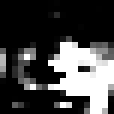

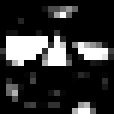

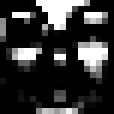

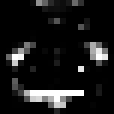

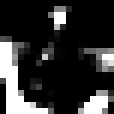

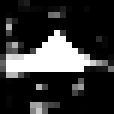

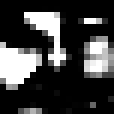

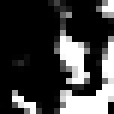

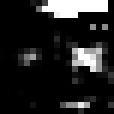

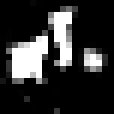

In [24]:
for i in 1:10
    display(colorview(Gray, reshape(W_pre_1[i, :], 19, 19)))
end

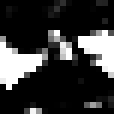

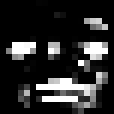

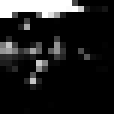

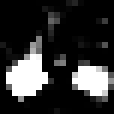

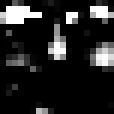

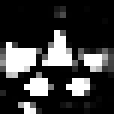

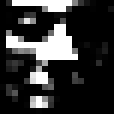

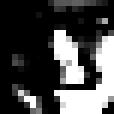

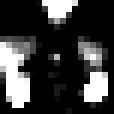

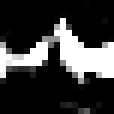

In [25]:
for i in 1:10
    display(colorview(Gray, reshape(W_pre_2[i, :], 19, 19)))
end

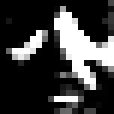

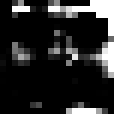

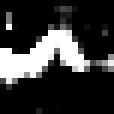

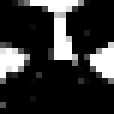

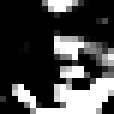

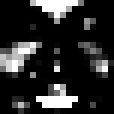

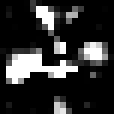

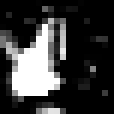

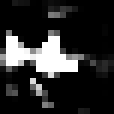

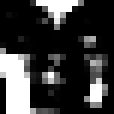

In [26]:
for i in 1:10
    display(colorview(Gray, reshape(W_pre_3[i, :], 19, 19)))
end

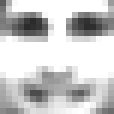

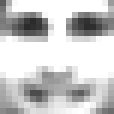

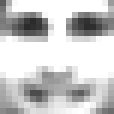

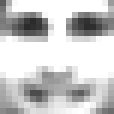

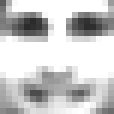

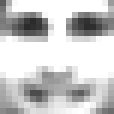

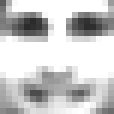

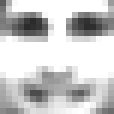

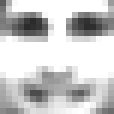

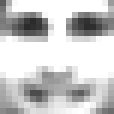

In [27]:
for i in 1:10
    display(colorview(Gray, reshape(W_pre_4[i, :], 19, 19)))
end

The estimates of W in first three cases are all providing the estimation of different parts of a human face, which is consistent with our expectations as this W provides the basis images of X. However, for the fourth estimate, as it stops at the local minimums, this W cannot provides basis images of X, which is not helpful to our factorization.

### Q1.7 GPU (optional)

Investigate the GPU capabilities of your computer. Report the speed gain of your GPU code over CPU code at ranks $r=10, 20, 30, 40, 50$. Make sure to use the same starting point as in Q1.3.

Currently, no packages are applicable on my MacBook Pro 2018 with Intel GPU.